In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import os
import gc
import time
import importlib
import sklearn.preprocessing as pp
import sklearn.model_selection as ms
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from recommender import item_based, dummy as dummy_recommender, preprocessing as rpp, model_selection as rms,\
    tools as rtools
import tag_genome_builder as tg_builder
from tag_genome_builder import model_selection as ms_tg_builder

from lib import tools
import config
import config_tag_recommender
def reload():
    importlib.reload(item_based)
    importlib.reload(dummy_recommender)
    importlib.reload(config)
    importlib.reload(tg_builder)
    importlib.reload(rpp)
    importlib.reload(rms)
    importlib.reload(tools)
    importlib.reload(config_tag_recommender)
    importlib.reload(ms_tg_builder)
    importlib.reload(rtools)
    
    

# input params

In [2]:
reload()
str_aggregated_path = config_tag_recommender.str_aggregated_path
str_genome_scores = config_tag_recommender.str_genome_scores
str_tag_ids = config_tag_recommender.str_tag_ids
str_rating_path = config_tag_recommender.str_rating_path
str_data_folder = config_tag_recommender.str_data_folder
minimum_no_of_frames = config_tag_recommender.minimum_no_of_frames
number_of_tag_per_movie = config_tag_recommender.number_of_tag_per_movie
n_jobs = 10

In [3]:
print('str_aggregated_path =', str_aggregated_path)
print('str_genome_scores =', str_genome_scores)
print('str_tag_ids =', str_tag_ids)
print('str_rating_path =', str_rating_path)
print('str_data_folder =', str_data_folder)
print('str_aggregated_path =', str_aggregated_path)
print('minimum_no_of_frames =', minimum_no_of_frames)
print('number_of_tag_per_movie =', number_of_tag_per_movie)

str_aggregated_path = C:\Users\shossein\Dropbox\Original Data\Elahi LowLevel Features\Mise-en-Scene Dataset_v1\LLVisualFeatures13K_Log.csv
str_genome_scores = ..\..\data\ml-25m\genome-scores.csv
str_tag_ids = ..\..\data\ml-25m\genome-tags.csv
str_rating_path = ..\..\data\ml-25m\ratings.csv
str_data_folder = ..\..\data
str_aggregated_path = C:\Users\shossein\Dropbox\Original Data\Elahi LowLevel Features\Mise-en-Scene Dataset_v1\LLVisualFeatures13K_Log.csv
minimum_no_of_frames = 10
number_of_tag_per_movie = 10


# Read inputs

In [4]:
df_tag_ids = pd.read_csv(str_tag_ids, index_col=config.tagId_col)

In [5]:
# df_tag_ids.head()

In [6]:
df_genome = pd.read_csv(str_genome_scores)

In [7]:
df_ratings = pd.read_csv(str_rating_path)

In [8]:
usecols = ['movieId', 'no_key_frames']
for i in range(1,11):
    usecols += [f'f{i}_median', f'f{i}_quartile1', f'f{i}_quartile3', f'f{i}_std'] 
print(len(usecols))
usecols = None


df_agg = pd.read_csv(str_aggregated_path, nrows=None, usecols=usecols, index_col=config.movieId_col).sort_index()
# df_agg = df_agg[df_agg['no_key_frames'] >= minimum_no_of_frames]
df_agg.dropna(axis=1, thresh=len(df_agg) - 1000, inplace=True)

42


In [9]:
print('The size of datasets before filtering to the same:')
print('VF:', df_agg.shape,'Tag genome:', df_genome[config.movieId_col].nunique())
df_agg, df_genome = tg_builder.Base().filter_tag_and_vf_to_same(df_agg=df_agg, df_genome_scores=df_genome)
print('The size of datasets after filtering to the same:')
print('VF:', df_agg.shape,'Tag genome:', df_genome[config.movieId_col].nunique())

The size of datasets before filtering to the same:
VF: (13373, 7) Tag genome: 13816
The size of datasets after filtering to the same:
VF: (6359, 7) Tag genome: 6359


In [10]:
item_features = rpp.get_item_feature_from_tag_genome(df_genome, number_of_tag_per_movie)

In [11]:
df_ratings_filtered = df_ratings[df_ratings[config.movieId_col].isin(item_features.item_ids)]
user_activities = df_ratings_filtered[config.userId_col].value_counts()
df_ratings_filtered = df_ratings_filtered[df_ratings_filtered[config.userId_col].\
                                          isin(user_activities[user_activities > 1].index)]

# Train test split
## rating dataset and tag item features

In [12]:
reload()
df_rating_train, df_rating_test, _, _ = \
    rms.train_test_split(df_ratings_filtered, item_features, strategy='sklearn', test_size=.25)

In [13]:
from tqdm import tqdm_notebook as tqdm

In [14]:
for number_of_tag_per_movie in tqdm(range(1, 11), total=10):
    item_features = rpp.get_item_feature_from_tag_genome(df_genome, number_of_tag_per_movie)
    item_features_train =\
        item_features.get_item_feature_by_list_of_items(df_rating_train[config.movieId_col].unique())
    item_features_test =\
            item_features.get_item_feature_by_list_of_items(df_rating_test[config.movieId_col].unique())
    recommend = item_based.ItemBasedColabCos()
    recommend.fit(df_rating_train, item_features_train)
    test_users = df_rating_test[config.userId_col].unique()
    recommendations = recommend.predict_on_list_of_users(test_users, df_rating_test, item_features_test, n_jobs=n_jobs)
    df_rating_test = rtools.prepare_recommendations_df(df_rating_test=df_rating_test,
                                                        recommendations=recommendations, 
                                                        prediction_column_suffix=f'tg_{number_of_tag_per_movie}')
    df_rating_test.to_csv(f'df_rating_test_tg{number_of_tag_per_movie}.csv')
# rate_normalizer = rpp.RatingNormalizer()
# df_rating_train[config.rating_col] = rate_normalizer.fit_transform(df_rating_train)
# df_rating_test[config.rating_col] = rate_normalizer.transform(df_rating_test)

# looking at the performance

1

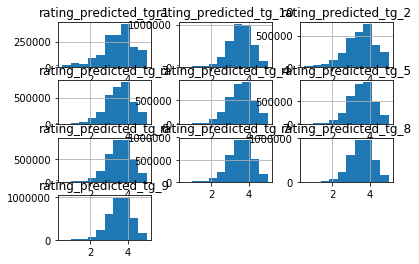

In [15]:
df_rating_test.filter(regex='rating_predicted').hist()
1

In [16]:
prediction_column_suffixes = []
for c in df_rating_test.filter(regex='rating_predicted').columns:
    c = c.replace('rating_predicted', '')
    c = c[1:] if len(c) > 0 else c
    prediction_column_suffixes.append(c)
prediction_column_suffixes

['tg_1',
 'tg_2',
 'tg_3',
 'tg_4',
 'tg_5',
 'tg_6',
 'tg_7',
 'tg_8',
 'tg_9',
 'tg_10']

In [17]:
reload()
df_performance_report = pd.concat([tools.performance_report(df_rating_test, 
                                                           prediction_column_suffix=alg) 
                                  for alg in prediction_column_suffixes]).sort_values('RMSE')
df_performance_report

,Average Score,MAE,RMSE,NRMSE,R2,Std of residuals,Avg of residuals
tg_10,3.491761,0.658713,0.855528,0.245013,0.349173,0.892831,-0.018180
tg_9,3.491761,0.658739,0.856202,0.245206,0.348147,0.895920,-0.017647
tg_8,3.491761,0.658327,0.856750,0.245363,0.347311,0.900205,-0.017583
tg_7,3.491761,0.658678,0.858706,0.245923,0.344328,0.905995,-0.019315
tg_6,3.491761,0.661060,0.862960,0.247142,0.337817,0.915334,-0.015755
tg_5,3.491761,0.664939,0.870799,0.249387,0.325731,0.927029,-0.015647
tg_4,3.491761,0.671719,0.883470,0.253016,0.305965,0.942752,-0.016562
tg_3,3.491761,0.681458,0.902256,0.258396,0.276136,0.963633,-0.011713
tg_2,3.491761,0.699002,0.938094,0.268659,0.217490,0.991439,-0.007933
tg_1,3.491761,0.753746,1.035483,0.296550,0.046581,1.035483,-0.000626


## performance table for copying into Latex

In [18]:
print(df_performance_report.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Average Score &       MAE &      RMSE &     NRMSE &        R2 &  Std of residuals &  Avg of residuals \\
\midrule
tg\_10 &       3.491761 &  0.658713 &  0.855528 &  0.245013 &  0.349173 &          0.892831 &         -0.018180 \\
tg\_9  &       3.491761 &  0.658739 &  0.856202 &  0.245206 &  0.348147 &          0.895920 &         -0.017647 \\
tg\_8  &       3.491761 &  0.658327 &  0.856750 &  0.245363 &  0.347311 &          0.900205 &         -0.017583 \\
tg\_7  &       3.491761 &  0.658678 &  0.858706 &  0.245923 &  0.344328 &          0.905995 &         -0.019315 \\
tg\_6  &       3.491761 &  0.661060 &  0.862960 &  0.247142 &  0.337817 &          0.915334 &         -0.015755 \\
tg\_5  &       3.491761 &  0.664939 &  0.870799 &  0.249387 &  0.325731 &          0.927029 &         -0.015647 \\
tg\_4  &       3.491761 &  0.671719 &  0.883470 &  0.253016 &  0.305965 &          0.942752 &         -0.016562 \\
tg\_3  &       3.491761 &  0.681458 &  0

## Some plots

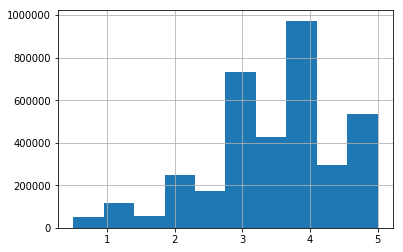

In [ ]:
df_rating_test[config.rating_col].hist()

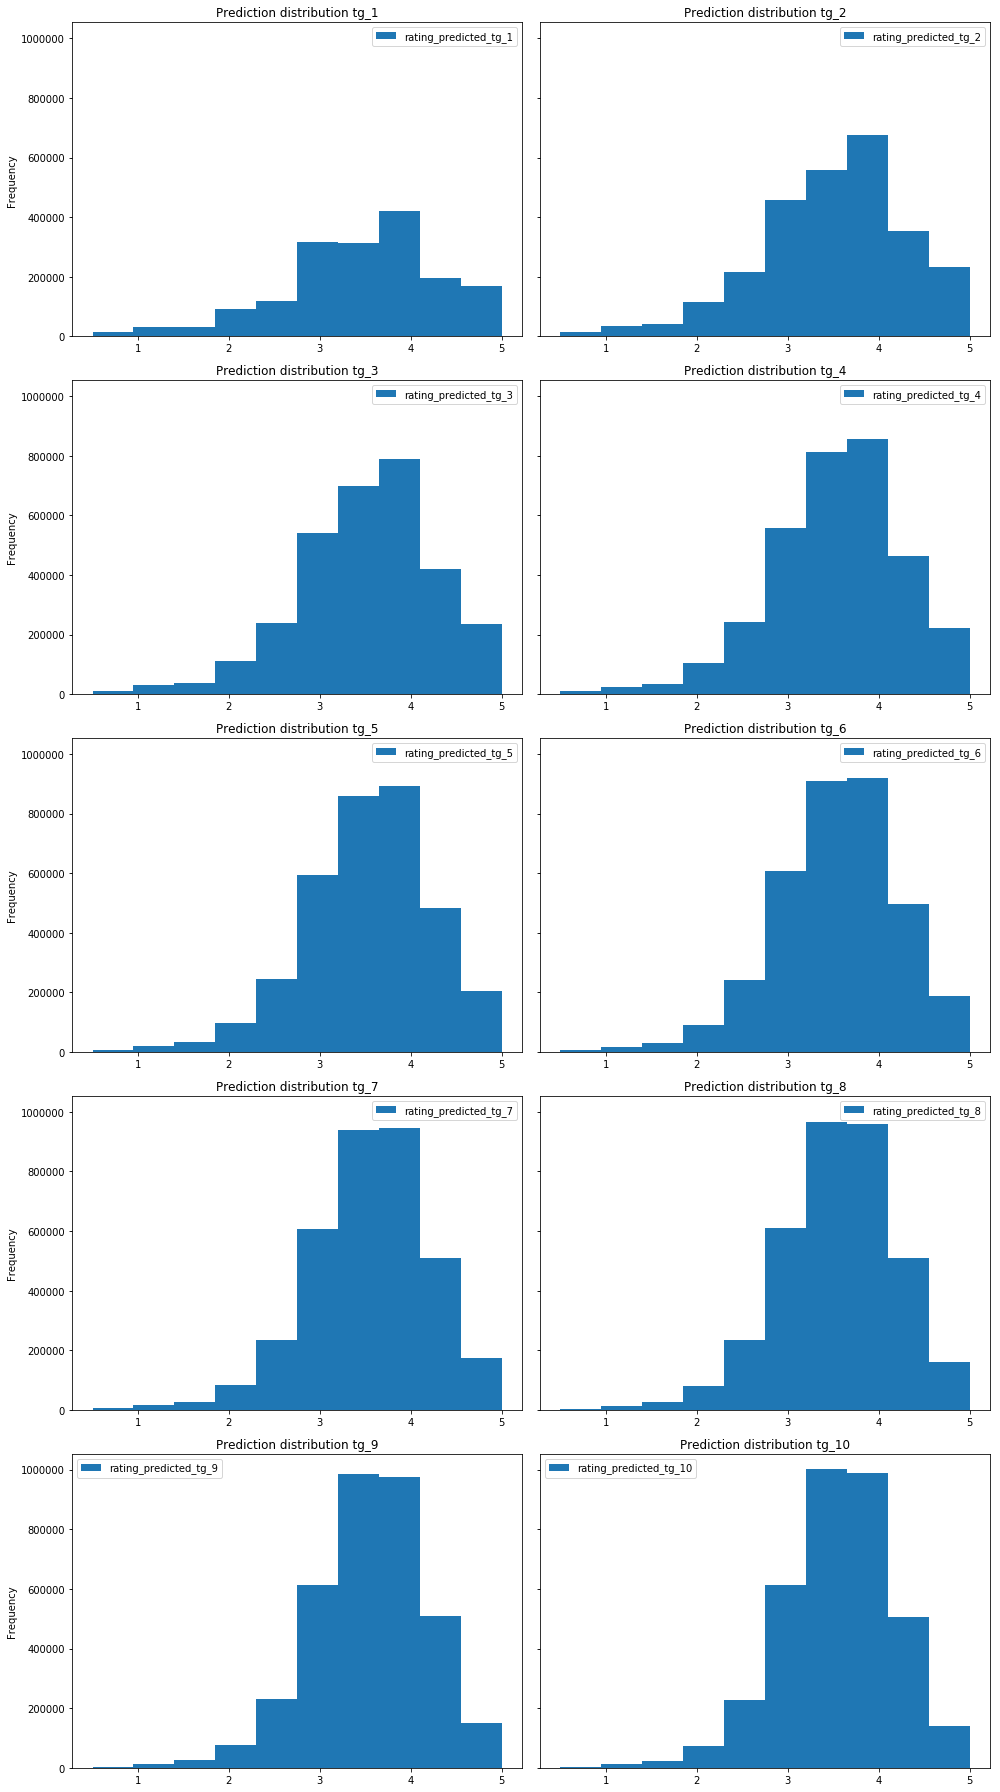

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_prediction_histogram,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

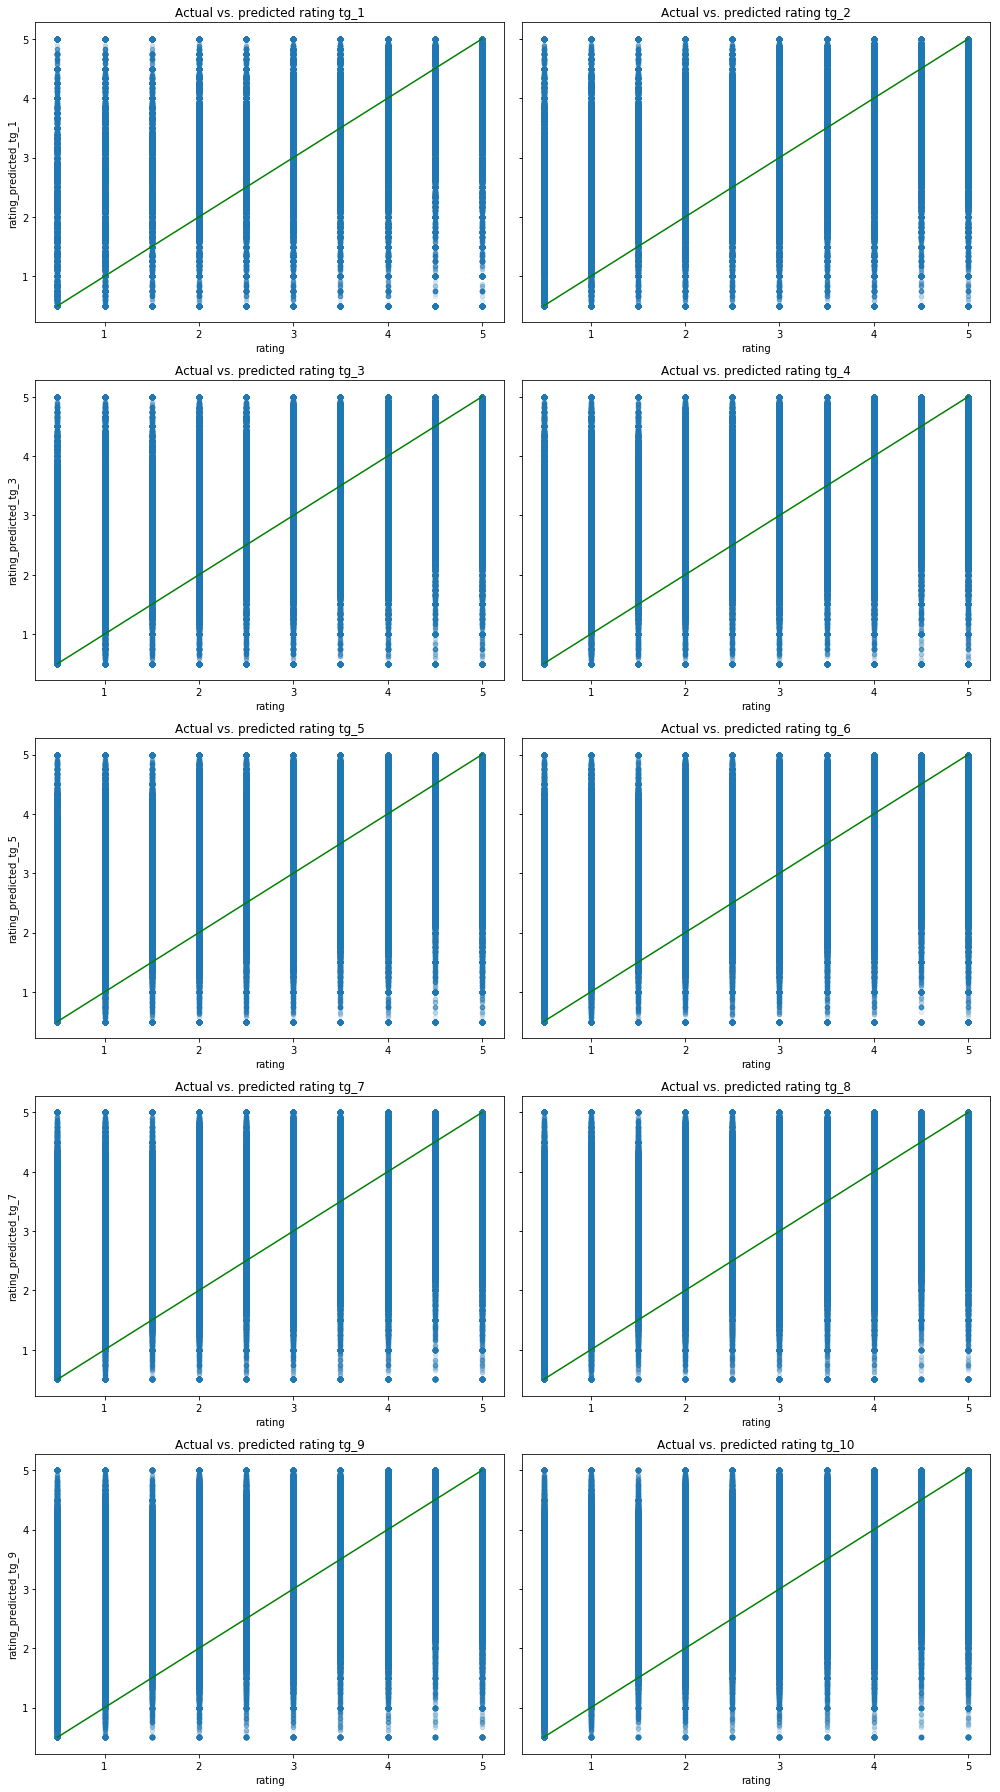

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_prediction,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes,
                            alpha=.1)

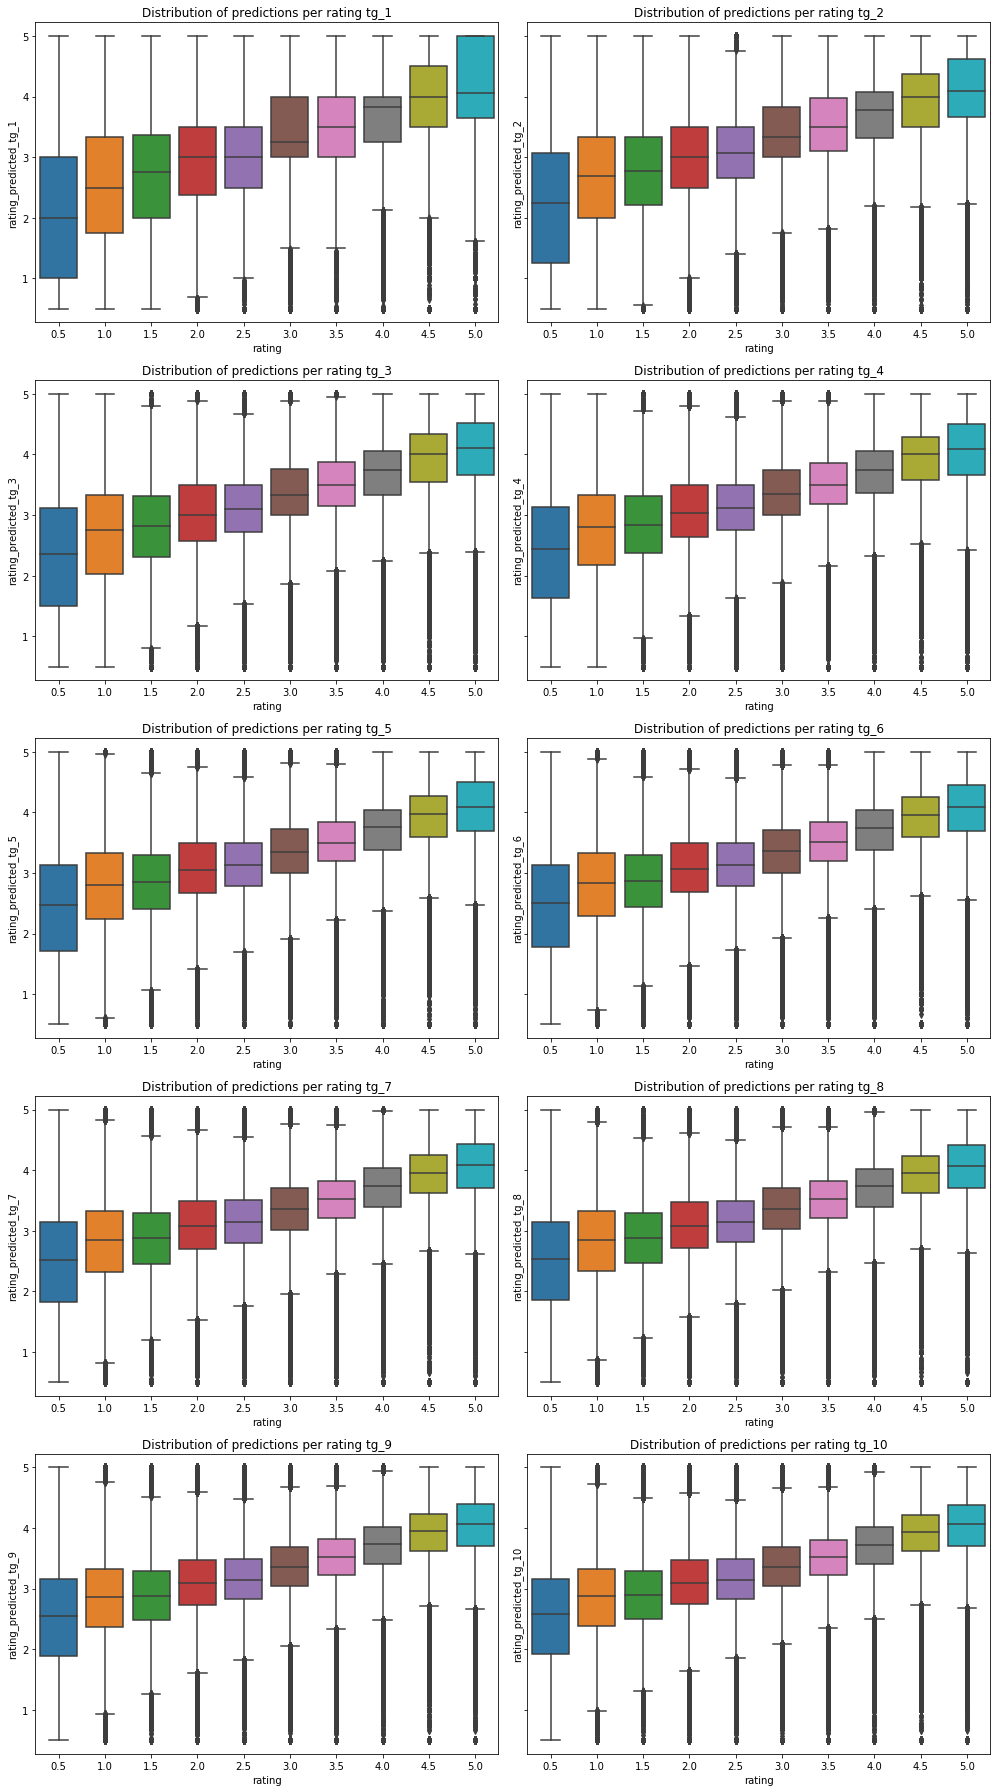

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_predicted_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

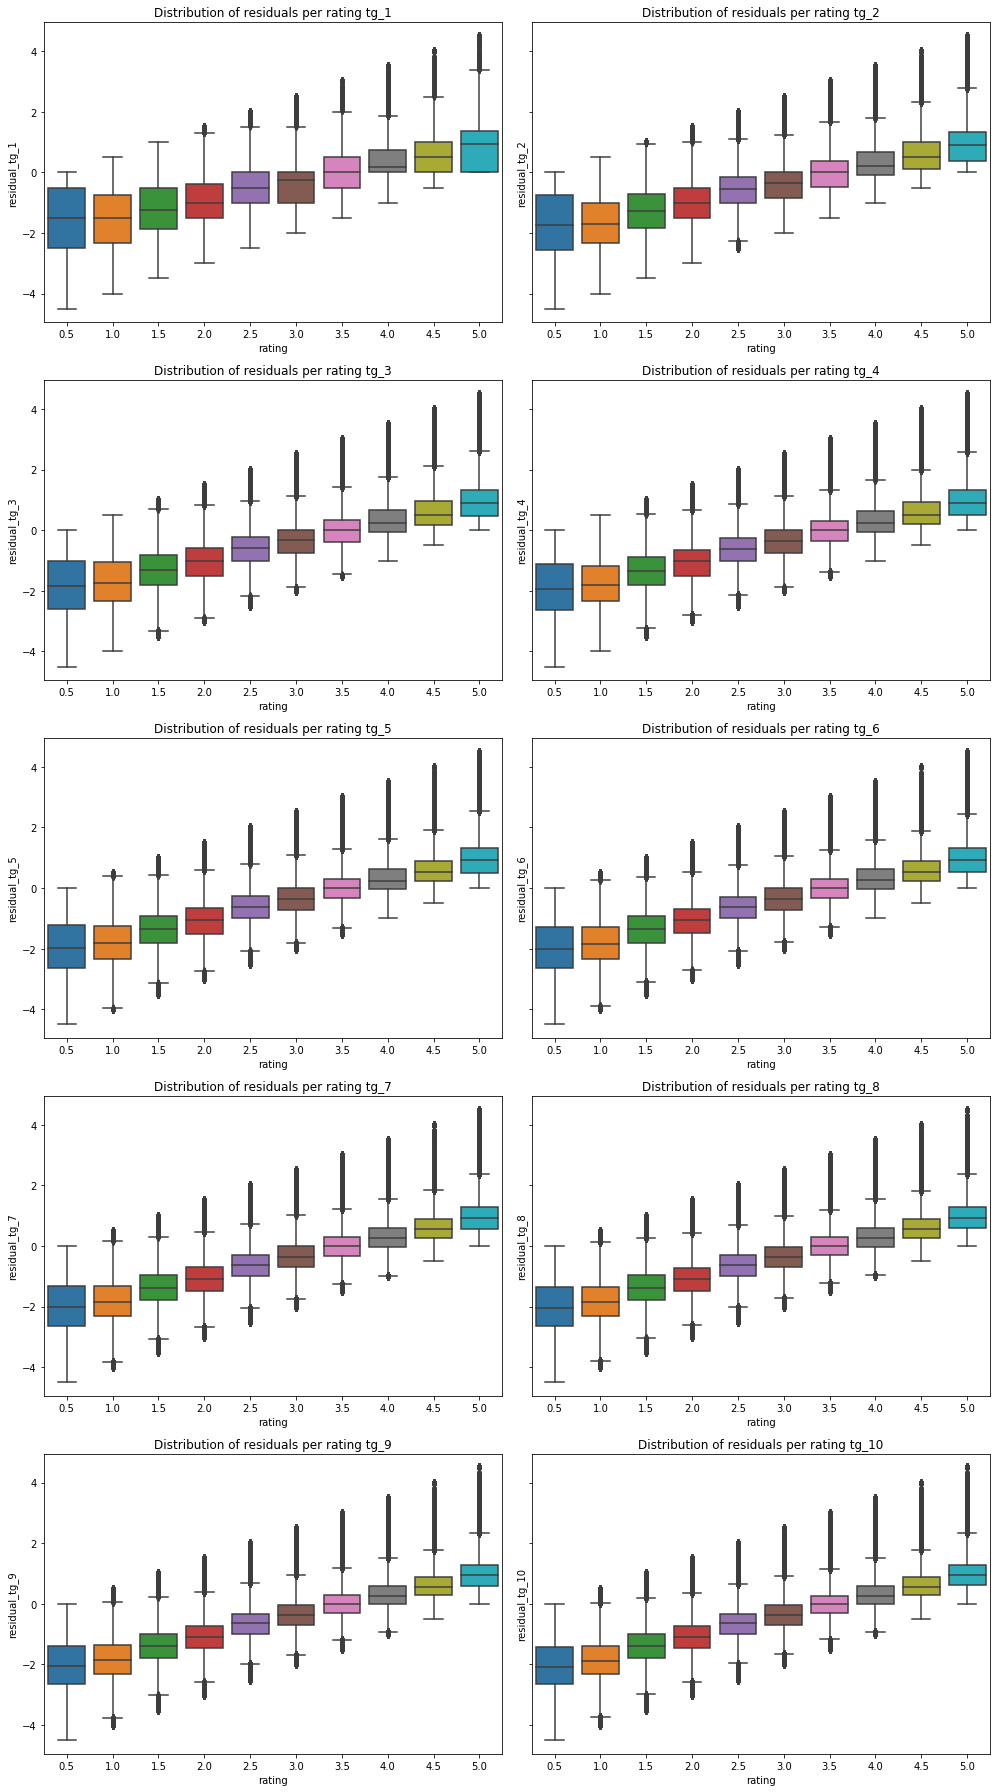

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_residual_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

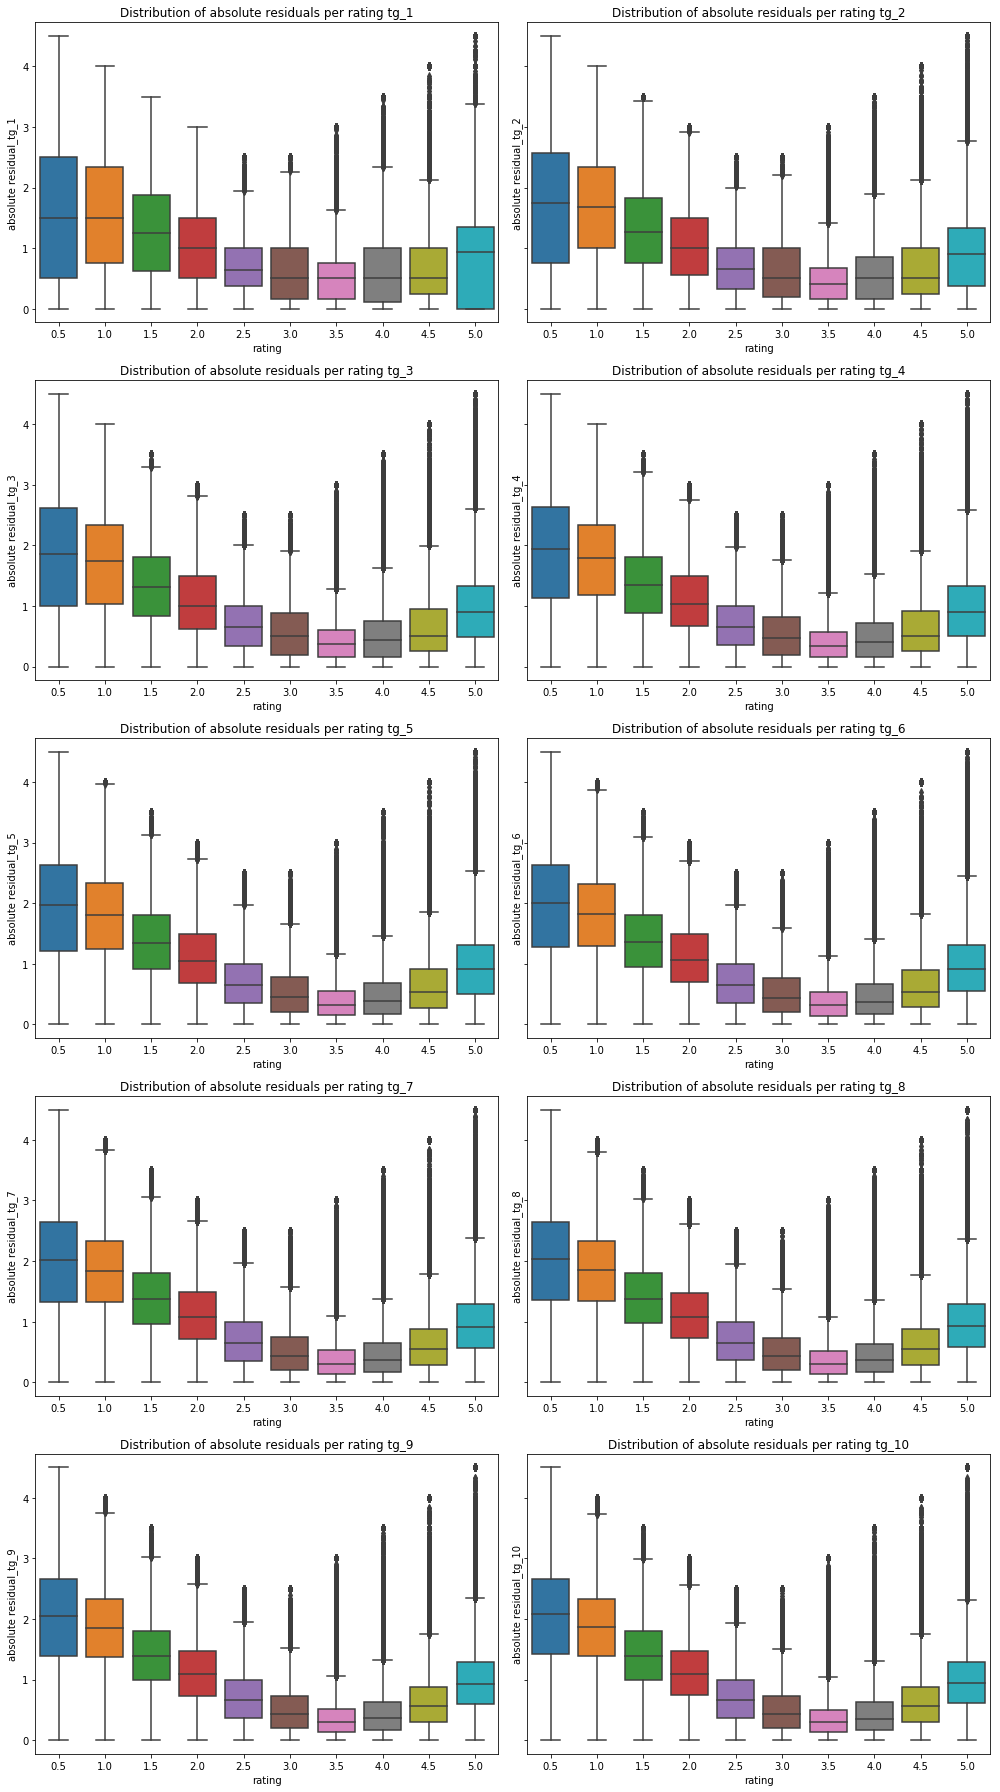

In [ ]:
reload()
_ = tools.plot_side_by_side(tools.plot_absolute_residual_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

In [ ]:
# reload()
# _ = tools.plot_side_by_side(tools.plot_actual_vs_predicted_violinplot,
#                             df_rating_pred=df_rating_test,
#                             prediction_column_suffixes=prediction_column_suffixes)

# Save the current notebook into results folder and push to the repository

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
from notebook import notebookapp
import urllib
import json
import os
import ipykernel

currentTime = lambda : time.strftime('%Y-%m-%d-%H%M')
def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

notebook_dir, notebook_name = os.path.split(notebook_path())
output = os.path.join(notebook_dir, 'output', f'{notebook_name}_{currentTime()}.ipynb')
os.system(f'jupyter nbconvert --to ipynb {notebook_path()} --output {output}')
os.system(f'git add {output}')
os.system(f'git commit -m "result computed on {currentTime()}"')
os.system('git push')

In [ ]:
df_rating_test.to_csv(os.path.join(notebook_dir, 'output', f'{notebook_name}_{currentTime()}_df_rating_test.csv'))